# Introduction
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>



## Business Objective
1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## About the Dataset
1. Available Columns: id, qid1, qid2, question1, question2, is_duplicate
2. Class labels: 0, 1
3. Total training data / No. of rows: 404290
4. No. of columns: 6
5. is_duplicate is the dependent variable.
6. No. of non-duplicate data points is 255027
7. No. of duplicate data points is 149263

We have 404290 training data points. And only 36.92% are positive. That means it is an imbalanced dataset.

# 1. Exploratory Data Analysis 

In [ ]:
!pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from subprocess import check_output
import os
import re
import gc
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import distance

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [ ]:
# load the dataset
df = pd.read_csv("/content/drive/MyDrive/quora_train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [ ]:
# dataset description
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [ ]:
# information about the attributes of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## 1. Distribution of data points among output classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

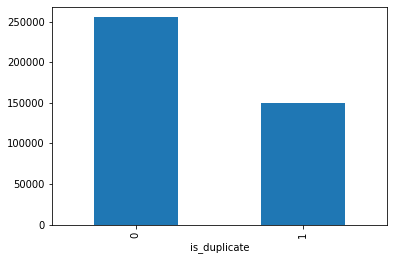

In [ ]:
# Barplot to see the number of duplicates and unique questions

df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
# Total number of question pairs for training...

print('~> Total number of question pairs for training: {}'.format(len(df)))

~> Total number of question pairs for training: 404290


In [ ]:
print('~> Question pairs are not Similar (is_duplicate = 0): {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('~> Question pairs are Similar (is_duplicate = 1): {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0): 63.08%
~> Question pairs are Similar (is_duplicate = 1): 36.92%


## 2. Number of unique questions

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist()) 
unique_qid = len(np.unique(qids))
print ('Total number of  Unique Questions are: {}'.format(unique_qid))

Total number of  Unique Questions are: 537933


In [ ]:
ques_more_than_one_time = np.sum(qids.value_counts() > 1)
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(ques_more_than_one_time,(ques_more_than_one_time/unique_qid)*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

qid_valcount = qids.value_counts()
qid_value = qid_valcount.values

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



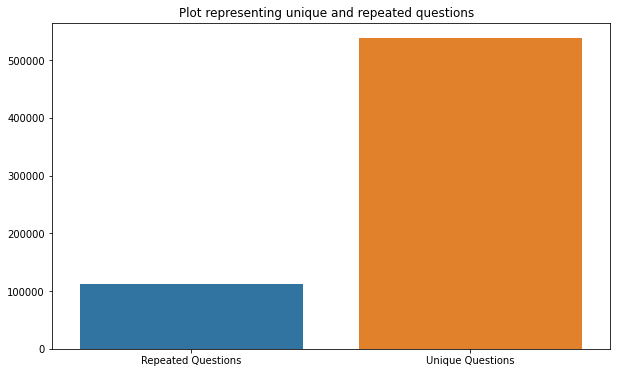

In [ ]:
x = ['Repeated Questions', 'Unique Questions']
y = [ques_more_than_one_time, unique_qid]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sb.barplot(x,y)
plt.show()

## 3. Checking for Duplicates

In [ ]:
duplicate_pairs = df[['id','qid1','qid2']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions: {}".format((duplicate_pairs).shape[0] - df.shape[0]))

Number of duplicate questions: 0


## 4. Number of occurrences of each question

Maximum number of times a single question is repeated: 157



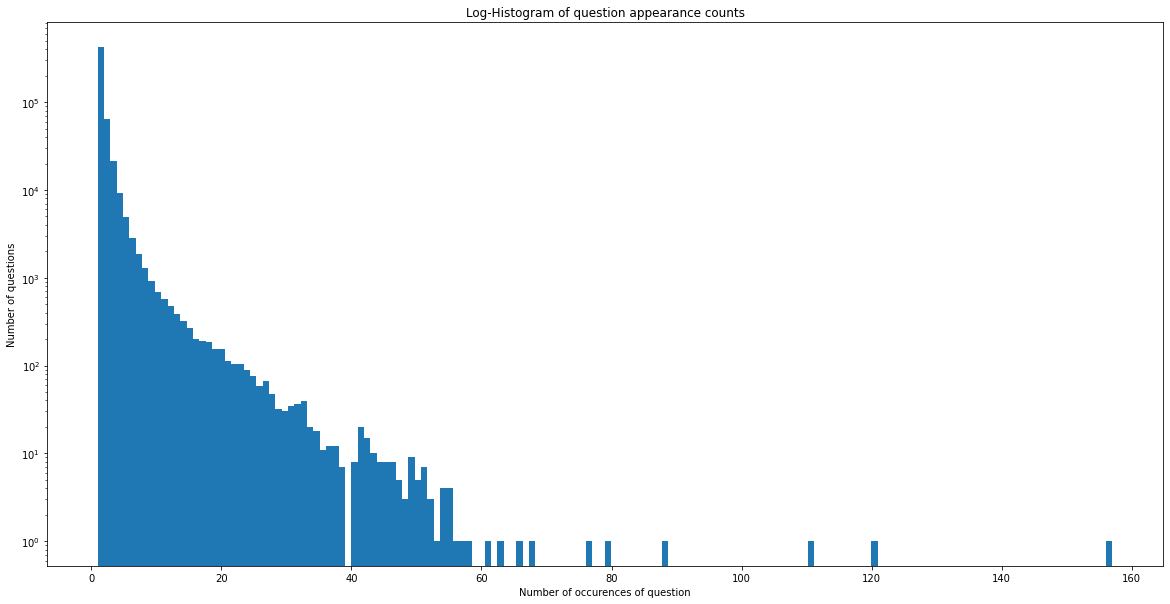

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log',nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## 5. Checking for NULL values

In [ ]:
#Checking whether there are any rows with null values

nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [ ]:
# Filling the null values with ' '

df = df.fillna(' ')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# 2. Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [ ]:
print("Minimum length of the questions in question1 : ",min(df['q1_n_words']))
print("Minimum length of the questions in question2 : {}".format(min(df['q2_n_words'])))

# print("Number of Questions with minimum length [question1] : {}".format(train[train['q1_n_words'] == 1].shape[0])
# print("Number of Questions with minimum length [question2] : {}".format(train[train['q2_n_words'] == 1].shape[0])

print("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 : 1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



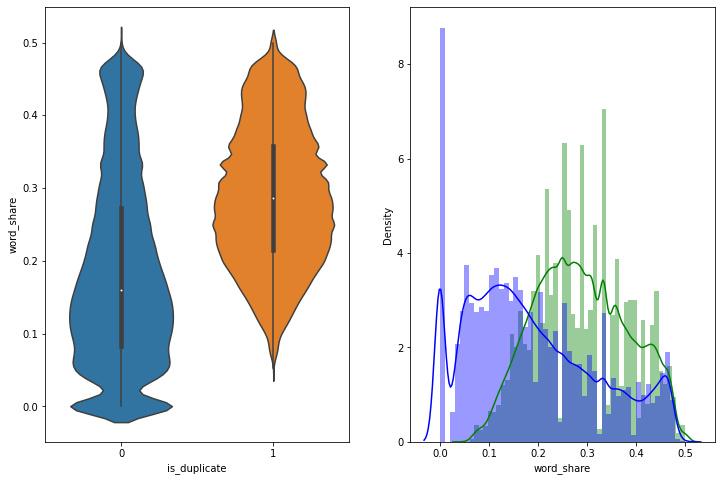

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sb.violinplot(x = 'is_duplicate',  y = 'word_share', data=df)

plt.subplot(1,2,2)
sb.distplot(df[df['is_duplicate']==1.0]['word_share'],label='1',color='green')
sb.distplot(df[df['is_duplicate']==0.0]['word_share'],label='0',color='blue')

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



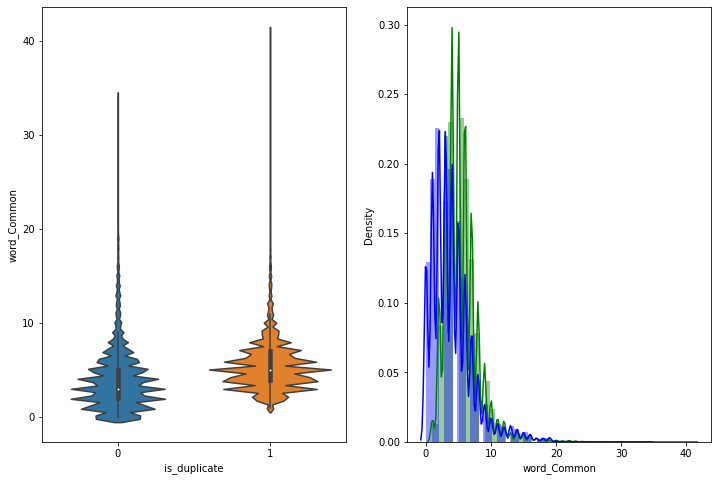

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sb.violinplot(x = 'is_duplicate',  y = 'word_Common', data=df)

plt.subplot(1,2,2)
sb.distplot(df[df['is_duplicate']==1.0]['word_Common'],label='1',color='green')
sb.distplot(df[df['is_duplicate']==0.0]['word_Common'],label='0',color='blue')

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>